## **1. Import Data**

In [1]:
# Supress warnings

import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, datetime, pytz, re, os, statsmodels.api as sm, joblib

#from sdv.tabular import CTGAN, CopulaGAN
from sklearn import (metrics, preprocessing, model_selection, feature_selection, linear_model, ensemble)
from sklearn.decomposition import PCA
from imblearn.over_sampling import (SMOTE, ADASYN)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# load 40% data

low_df_40 = pd.read_excel('40_modelling_data.xlsx')
low_df_40.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response,Less_than_1_year,More_than_2_years,Region_Code_10,...,Region_Code_6,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26
0,0,25,0,1,26742,180,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,42,0,0,2630,160,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,24,1,0,30691,74,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1,33,0,1,33735,210,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,23,0,1,36746,181,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
# Take copy of data

md_data_40 = low_df_40.copy()
md_data_40.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response,Less_than_1_year,More_than_2_years,Region_Code_10,...,Region_Code_6,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26
0,0,25,0,1,26742,180,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,42,0,0,2630,160,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,24,1,0,30691,74,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1,33,0,1,33735,210,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,23,0,1,36746,181,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# continuous variables

cont_vars = ['Age', 'Annual_Premium', 'Vintage']

<AxesSubplot:>

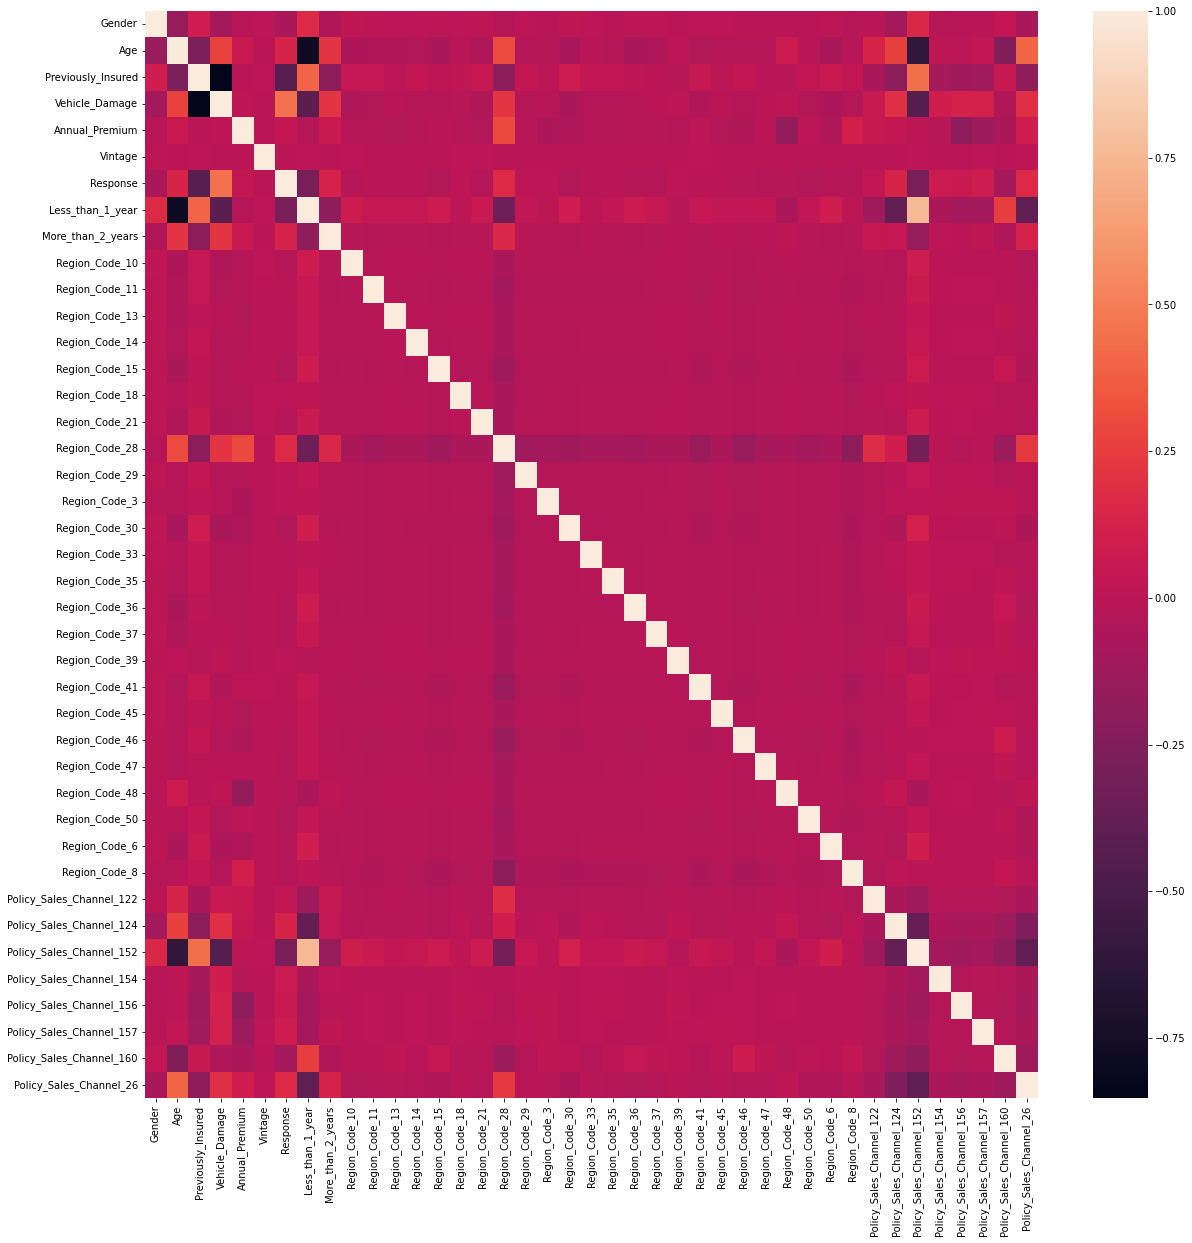

In [5]:
# correlation plot

plt.figure(figsize=(20,20))
sns.heatmap(md_data_40.corr())

In [6]:
# Reusable Functions

def normalize_train_test_split(df, cont_vars, return_balanced_data=False):
    
    y = df.pop('Response')
    
    lr_X_train, lr_X_val, lr_y_train, lr_y_val = model_selection.train_test_split(df, y, train_size=0.7, random_state=42, stratify=y)
    print(lr_X_train.shape, lr_X_val.shape)

    # normalize continuous variables

    scaler = preprocessing.StandardScaler()
    lr_X_train[cont_vars] = scaler.fit_transform(lr_X_train[cont_vars])
    lr_X_val[cont_vars] = scaler.transform(lr_X_val[cont_vars])
    
    # Balance the imbalance data
    
    if return_balanced_data:
        ada = ADASYN(random_state=42, n_jobs=-1)
        lr_X_train, lr_y_train = ada.fit_resample(lr_X_train, lr_y_train)
    print(lr_X_train.shape, lr_y_train.shape, lr_X_val.shape, lr_y_val.shape)
    return lr_X_train, lr_y_train, lr_X_val, lr_y_val

# Function for smote and adasyn oversampling

def smote_adasyn_synthetic_data(df_x, df_y):
    y = df_y
    
    sampling_strategy={0:(len(df_x)-sum(y))*2, 1:sum(y)*2}
    smote_obj = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    adasyn_obj = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
    
    X_smote, y_smote = smote_obj.fit_resample(df_x, y)
    X_adasyn, y_adasyn = adasyn_obj.fit_resample(df_x, y)
    
    print(X_smote.shape, y_smote.shape, X_adasyn.shape, y_adasyn.shape, sum(y_smote), sum(y_adasyn))
    return X_smote, y_smote, X_adasyn, y_adasyn

def rfe_feature_selection(model_obj, train_df_X, train_df_y, col_num):

    rfe = feature_selection.RFE(estimator=model_obj, n_features_to_select=col_num)
    rfe = rfe.fit(train_df_X, train_df_y)

    col = list(train_df_X.columns[rfe.support_])
    print(len(col))
    return col

# functions to fit the model, calculate accuracy and vif

def run_statsmodel(df_X, df_y):
    X_train_rfe = sm.add_constant(df_X)
    lm = sm.GLM(df_y, X_train_rfe, family=sm.families.Binomial()).fit()
    return lm.summary(), lm

def calculate_accuracy(lm, var_list, df, labels, predict_proba=False):
    if predict_proba:
        lr_y_train_pred = lm.predict_proba(df)[:,1]
    else:
        lr_y_train_pred = lm.predict(sm.add_constant(df[var_list])).values.reshape(-1)
    df = pd.DataFrame()
    df['Converted'] = labels.values
    df['Conv_Prob'] = lr_y_train_pred
    df['Predicted'] = df['Conv_Prob'].apply(lambda x : 1 if x > 0.5 else 0)
    cm = metrics.confusion_matrix(df['Converted'], df['Predicted'])
    accuracy = metrics.accuracy_score(df['Converted'], df['Predicted'])
    return df, cm, round(accuracy, 3)

def calculate_VIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [round(variance_inflation_factor(df.values, i),2) for i in range(df.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def calculate_accuracy_vif(trained_model, col_list, train_df, labels):
    y_train_pred, cm_matrix, model_accuracy = calculate_accuracy(trained_model, col_list, train_df, labels)
    print(f'Accuracy of Model is {model_accuracy}')
    VIF_df = calculate_VIF(train_df[col_list])
    print(cm_matrix)
    return y_train_pred, cm_matrix, VIF_df

def calculate_oprimal_threshold(fpr, tpr, thresholds):
    df_roc = pd.DataFrame()
    df_roc['thresholds'] = thresholds
    df_roc['tpr'] = tpr
    df_roc['fpr'] = fpr
    df_roc['spec'] = 1-fpr
    df_roc['diff'] = np.abs(df_roc['tpr']-df_roc['spec'])
    df_roc = df_roc.sort_values('diff')
    return df_roc 
    
def evaluate_model(df, pred, train=True):
    cm = metrics.confusion_matrix(df['Converted'], df[pred])
    TP = cm[1,1] # True Positive
    TN = cm[0,0] # True Negative
    FP = cm[0,1] # False Positive
    FN = cm[1,0] # False Negative
    acc = round(metrics.accuracy_score(df['Converted'], df[pred]), 3)
    rv = round(metrics.recall_score(df['Converted'], df[pred]), 3)
    pv = round(metrics.precision_score(df['Converted'], df[pred]), 3)
    f1 = round(metrics.f1_score(df['Converted'], df[pred]), 3)
    auc = round(metrics.roc_auc_score(df['Converted'], df['Conv_Prob']), 3)
    sv = round(TN / float(TN+FP), 3)
    g_mean = round(np.sqrt(rv*sv), 3)
    print_str = f'Accuracy: {acc}, Recall: {rv}, Precision: {pv}, F1-score: {f1}, AUC: {auc}, Specificity: {sv}, G-Mean: {g_mean}'
    if train:
        fpr, tpr, thresholds = metrics.roc_curve(df['Converted'], df['Conv_Prob'])
        df_roc = calculate_oprimal_threshold(fpr, tpr, thresholds)
        print(df_roc.head())
        opt_threshold = round(df_roc.iloc[0]['thresholds'], 2)
        print_str += f', Optimal Threshold: {opt_threshold}'
        print(print_str)
        return fpr, tpr, thresholds, opt_threshold
    else:
        print(print_str)
    
    
def calculate_labels_at_diff_thresholds(df):  
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i]= df['Conv_Prob'].map(lambda x: 1 if x > i else 0)

    cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

    for i in numbers:
        cm1 = metrics.confusion_matrix(df['Converted'], df[i])
        accuracy = metrics.accuracy_score(df['Converted'], df[i])
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[int(i*10)] =[i ,accuracy,sensi,speci]
    return cutoff_df

def evaluate_model_on_test_data(mdl_obj, val_x, cols_list, val_y, threshold_val, predict_proba=False):
    if predict_proba:
        y_test_pred = mdl_obj.predict_proba(val_x)[:,1]
    else:
        y_test_pred = mdl_obj.predict(sm.add_constant(val_x[cols_list]))
    y_test_pred_final = pd.DataFrame()
    y_test_pred_final['Converted'] = val_y
    y_test_pred_final['Conv_Prob'] = y_test_pred
    y_test_pred_final['final_predicted'] = y_test_pred_final.Conv_Prob.map(lambda x: 1 if x > threshold_val else 0)
    evaluate_model(y_test_pred_final, pred='final_predicted', train=False)

In [7]:
# Split the data

lr_X_train_40, lr_y_train_40, lr_X_val_40, lr_y_val_40 = normalize_train_test_split(md_data_40, cont_vars, return_balanced_data=False)

(107002, 40) (45859, 40)
(107002, 40) (107002,) (45859, 40) (45859,)


In [8]:
%%time
# Enhance data with Synthetic data

X_train_low_40_smote, y_train_low_40_smote, X_train_low_40_adasyn, y_train_low_40_adasyn = smote_adasyn_synthetic_data(lr_X_train_40, lr_y_train_40)

(214004, 40) (214004,) (211558, 40) (211558,) 35056 34262
Wall time: 16min 26s


In [9]:
# Train data

lr_X_train_40_gan = lr_X_train_40.copy()
lr_X_train_40_gan['Response'] = lr_y_train_40.copy()
lr_X_train_40_gan

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
145150,0,0.357135,0,1,1.261783,1.342616,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
83118,0,-1.021880,1,0,-1.653419,1.461934,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
73457,1,0.160133,1,0,0.088834,1.187503,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121209,0,-0.299539,1,0,-0.200707,0.292619,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14337,0,-1.087548,1,0,-0.320210,0.400005,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86764,0,1.342146,1,0,-1.653419,1.473866,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
37457,1,-0.956213,1,0,-0.209129,1.402275,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
93934,1,1.079476,0,1,0.662616,-1.580670,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
102220,0,-0.102537,0,1,0.704551,0.829550,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
# load synthetic data generated by GAN

gan_data_40 = pd.read_excel('20220818061858641143cp_syn_data_40_train.xlsx')[lr_X_train_40_gan.columns]
gan_data_40

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
0,1,24,1,0,26540,132,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,23,1,0,40600,259,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,73,0,1,2630,97,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,35,1,0,45806,106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,23,0,1,32847,157,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106997,1,26,0,0,23171,288,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
106998,0,31,0,1,29603,143,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
106999,0,23,0,0,29149,297,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
107000,1,21,0,1,47354,285,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
# Balance the train data

scaler = preprocessing.StandardScaler()
gan_data_40[cont_vars] = scaler.fit_transform(gan_data_40[cont_vars])
X_train_low_40_gan = pd.concat([lr_X_train_40_gan, gan_data_40])
X_train_low_40_gan

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
145150,0,0.357135,0,1,1.261783,1.342616,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
83118,0,-1.021880,1,0,-1.653419,1.461934,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
73457,1,0.160133,1,0,0.088834,1.187503,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121209,0,-0.299539,1,0,-0.200707,0.292619,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14337,0,-1.087548,1,0,-0.320210,0.400005,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106997,1,-0.819202,0,0,-0.550948,1.501326,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
106998,0,-0.512665,0,1,-0.177966,-0.211425,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
106999,0,-1.003125,0,0,-0.204293,1.607634,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
107000,1,-1.125740,0,1,0.851386,1.465889,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
# prepare X_train and y_train

y_train_low_40_gan = X_train_low_40_gan.pop('Response')
X_train_low_40_gan = X_train_low_40_gan

## **2. Logistic Regression**
### **2.1 Original Data**

In [13]:
# Automated feature selection

logreg_rfe_40_base = linear_model.LogisticRegression()
logreg_rfe_40_base.fit(lr_X_train_40, lr_y_train_40)
col_base_40 = rfe_feature_selection(logreg_rfe_40_base, lr_X_train_40, lr_y_train_40, 15)

15


In [14]:
# Fit model with 15 cols

col_1_base_40 = col_base_40.copy()
mod_1_base_40, lm_1_base_40 = run_statsmodel(lr_X_train_40[col_1_base_40], lr_y_train_40)
mod_1_base_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               107002
Model:                            GLM   Df Residuals:                   106986
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30346.
Date:                Thu, 18 Aug 2022   Deviance:                       60692.
Time:                        15:39:17   Pearson chi2:                 9.74e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2772
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.7014      0.071    -37.897      0.000      -2.841      -2.562
Age                         -0.5772      0.015    -38.050      0.000      -0.607      -0.548
Previously_Insured          -4.3090      0.176    -24.442      0.000      -4.655      -3.964
Vehicle_Damage               2.4638      0.071     34.780      0.000       2.325       2.603
Less_than_1_year            -0.7539      0.042    -17.871      0.000      -0.837      -0.671
Region_Code_11               0.4149      0.072      5.762      0.000       0.274       0.556
Region_Code_18               0.6214      0.089      6.990      0.000       0.447       0.796
Region_Code_29               0.3542      0.060      5.925      0.000       0.237       0.471
Region_Code_3                0.3622      0.064      5.677      0.000       0.237       0.487
Region_Code_35               0.3810      0.076      5.034      0.000       0.233       0.529
Region_Code_41               0.4155      0.049      8.512      0.000       0.320       0.511
Region_Code_48              -0.9625      0.111     -8.710      0.000      -1.179      -0.746
Region_Code_50              -0.5694      0.083     -6.880      0.000      -0.732      -0.407
Policy_Sales_Channel_152    -1.4635      0.049    -29.628      0.000      -1.560      -1.367
Policy_Sales_Channel_160    -2.5173      0.106    -23.749      0.000      -2.725      -2.310
Policy_Sales_Channel_26      0.3898      0.022     17.918      0.000       0.347       0.432
============================================================================================
"""

In [15]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_base_40, lr_cm_1_base_40, lr_VIF_1_base_40 = calculate_accuracy_vif(lm_1_base_40, col_1_base_40, lr_X_train_40, lr_y_train_40)
lr_VIF_1_base_40

Accuracy of Model is 0.837
[[86041  3433]
 [14051  3477]]


,Features,VIF
3,Less_than_1_year,8.28
12,Policy_Sales_Channel_152,6.09
1,Previously_Insured,2.95
0,Age,2.57
2,Vehicle_Damage,1.83
13,Policy_Sales_Channel_160,1.76
14,Policy_Sales_Channel_26,1.55
9,Region_Code_41,1.06
6,Region_Code_29,1.04
4,Region_Code_11,1.03


In [16]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_base_40.remove('Less_than_1_year')

col_2_base_40 = col_1_base_40.copy()
mod_2_base_40, lm_2_base_40 = run_statsmodel(lr_X_train_40[col_2_base_40], lr_y_train_40)
mod_2_base_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               107002
Model:                            GLM   Df Residuals:                   106987
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30508.
Date:                Thu, 18 Aug 2022   Deviance:                       61017.
Time:                        15:39:21   Pearson chi2:                 9.57e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2750
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8363      0.071    -40.010      0.000      -2.975      -2.697
Age                         -0.4582      0.013    -34.247      0.000      -0.484      -0.432
Previously_Insured          -4.3151      0.176    -24.483      0.000      -4.661      -3.970
Vehicle_Damage               2.4922      0.071     35.219      0.000       2.353       2.631
Region_Code_11               0.4170      0.072      5.817      0.000       0.276       0.557
Region_Code_18               0.6233      0.089      7.039      0.000       0.450       0.797
Region_Code_29               0.3706      0.060      6.226      0.000       0.254       0.487
Region_Code_3                0.3517      0.064      5.527      0.000       0.227       0.476
Region_Code_35               0.3890      0.075      5.153      0.000       0.241       0.537
Region_Code_41               0.4112      0.049      8.444      0.000       0.316       0.507
Region_Code_48              -0.9539      0.110     -8.657      0.000      -1.170      -0.738
Region_Code_50              -0.5750      0.083     -6.966      0.000      -0.737      -0.413
Policy_Sales_Channel_152    -1.9545      0.041    -47.226      0.000      -2.036      -1.873
Policy_Sales_Channel_160    -3.0050      0.103    -29.307      0.000      -3.206      -2.804
Policy_Sales_Channel_26      0.3779      0.022     17.449      0.000       0.335       0.420
============================================================================================
"""

In [17]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_base_40, lr_cm_2_base_40, lr_VIF_2_base_40 = calculate_accuracy_vif(lm_2_base_40, col_2_base_40, lr_X_train_40, lr_y_train_40)
lr_VIF_2_base_40

Accuracy of Model is 0.831
[[86163  3311]
 [14778  2750]]


,Features,VIF
11,Policy_Sales_Channel_152,3.36
1,Previously_Insured,2.69
0,Age,1.97
2,Vehicle_Damage,1.66
13,Policy_Sales_Channel_26,1.54
12,Policy_Sales_Channel_160,1.37
8,Region_Code_41,1.06
5,Region_Code_29,1.04
3,Region_Code_11,1.03
6,Region_Code_3,1.03


In [18]:
# Training predictions and Confusion matrix

train_pred_model_40 = lm_2_base_40
train_cols_40 = col_2_base_40
train_pred_df_40 = lr_y_train_pred_final_2_base_40
train_pred_cm_40 = lr_cm_2_base_40

In [19]:
# Evaluate model

_, _, _, opt_threshold_base_40 = evaluate_model(train_pred_df_40, pred='Predicted')

     thresholds       tpr       fpr      spec      diff
643    0.335900  0.812586  0.185015  0.814985  0.002400
642    0.336530  0.812586  0.184948  0.815052  0.002467
641    0.337197  0.812529  0.184948  0.815052  0.002524
640    0.337423  0.812529  0.184936  0.815064  0.002535
639    0.337656  0.812300  0.184892  0.815108  0.002808
Accuracy: 0.831, Recall: 0.157, Precision: 0.454, F1-score: 0.233, AUC: 0.882, Specificity: 0.963, G-Mean: 0.389, Optimal Threshold: 0.34


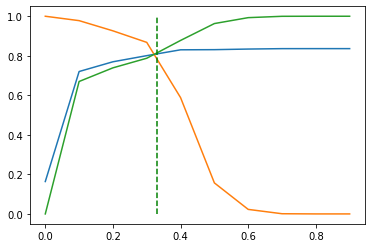

In [20]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_base_40 = calculate_labels_at_diff_thresholds(train_pred_df_40)
plt.plot(cutoff_df_base_40['prob'], cutoff_df_base_40['accuracy'])
plt.plot(cutoff_df_base_40['prob'], cutoff_df_base_40['sensi'])
plt.plot(cutoff_df_base_40['prob'], cutoff_df_base_40['speci'])
plt.vlines(x=.33, ymax=1, ymin=0, colors='g', linestyles='--')

In [21]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_40['final_predicted'] = train_pred_df_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_base_40 else 0)
evaluate_model(train_pred_df_40, pred='final_predicted')
train_pred_df_40.head()

     thresholds       tpr       fpr      spec      diff
643    0.335900  0.812586  0.185015  0.814985  0.002400
642    0.336530  0.812586  0.184948  0.815052  0.002467
641    0.337197  0.812529  0.184948  0.815052  0.002524
640    0.337423  0.812529  0.184936  0.815064  0.002535
639    0.337656  0.812300  0.184892  0.815108  0.002808
Accuracy: 0.815, Recall: 0.809, Precision: 0.464, F1-score: 0.589, AUC: 0.882, Specificity: 0.817, G-Mean: 0.813, Optimal Threshold: 0.34


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.467568,0,1,1,1,1,1,0,0,0,0,0,1
1,0,0.001823,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.001073,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.000127,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.001879,0,1,0,0,0,0,0,0,0,0,0,0


In [22]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model_40, lr_X_val_40, train_cols_40, lr_y_val_40, opt_threshold_base_40)

Accuracy: 0.813, Recall: 0.804, Precision: 0.46, F1-score: 0.585, AUC: 0.878, Specificity: 0.815, G-Mean: 0.809


## **2.2 SMOTE Data**

In [23]:
# Automated feature selection

logreg_rfe_smote_40 = linear_model.LogisticRegression()
logreg_rfe_smote_40.fit(X_train_low_40_smote, y_train_low_40_smote)
col_smote_40 = rfe_feature_selection(logreg_rfe_smote_40, X_train_low_40_smote, y_train_low_40_smote, 15)

15


In [24]:
# Fit model with 15 cols

col_1_smote_40 = col_smote_40.copy()
mod_1_smote_40, lm_1_smote_40 = run_statsmodel(X_train_low_40_smote[col_1_smote_40], y_train_low_40_smote)
mod_1_smote_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               214004
Model:                            GLM   Df Residuals:                   213988
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60622.
Date:                Thu, 18 Aug 2022   Deviance:                   1.2124e+05
Time:                        15:40:55   Pearson chi2:                 1.95e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2777
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5978      0.050    -52.406      0.000      -2.695      -2.501
Age                         -0.6226      0.011    -56.363      0.000      -0.644      -0.601
Previously_Insured          -4.8909      0.172    -28.440      0.000      -5.228      -4.554
Vehicle_Damage               2.4009      0.049     48.616      0.000       2.304       2.498
Less_than_1_year            -0.8514      0.031    -27.779      0.000      -0.911      -0.791
Region_Code_11               0.4234      0.054      7.842      0.000       0.318       0.529
Region_Code_18               0.6029      0.067      8.986      0.000       0.471       0.734
Region_Code_35               0.3784      0.056      6.731      0.000       0.268       0.489
Region_Code_37              -0.5935      0.085     -6.994      0.000      -0.760      -0.427
Region_Code_41               0.3559      0.035     10.206      0.000       0.288       0.424
Region_Code_47              -0.4153      0.061     -6.772      0.000      -0.536      -0.295
Region_Code_48              -1.1928      0.085    -13.970      0.000      -1.360      -1.025
Region_Code_50              -0.7816      0.064    -12.136      0.000      -0.908      -0.655
Policy_Sales_Channel_152    -1.4278      0.036    -39.914      0.000      -1.498      -1.358
Policy_Sales_Channel_160    -2.5100      0.077    -32.533      0.000      -2.661      -2.359
Policy_Sales_Channel_26      0.4097      0.015     26.635      0.000       0.380       0.440
============================================================================================
"""

In [25]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_smote_40, lr_cm_1_smote_40, lr_VIF_1_smote_40 = calculate_accuracy_vif(lm_1_smote_40, col_1_smote_40, X_train_low_40_smote, y_train_low_40_smote)
lr_VIF_1_smote_40

Accuracy of Model is 0.837
[[172072   6876]
 [ 28032   7024]]


,Features,VIF
3,Less_than_1_year,8.54
12,Policy_Sales_Channel_152,6.23
1,Previously_Insured,2.97
0,Age,2.65
2,Vehicle_Damage,1.84
13,Policy_Sales_Channel_160,1.79
14,Policy_Sales_Channel_26,1.55
8,Region_Code_41,1.06
4,Region_Code_11,1.03
11,Region_Code_50,1.03


In [26]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_smote_40.remove('Less_than_1_year')

col_2_smote_40 = col_1_smote_40.copy()
mod_2_smote_40, lm_2_smote_40 = run_statsmodel(X_train_low_40_smote[col_2_smote_40], y_train_low_40_smote)
mod_2_smote_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               214004
Model:                            GLM   Df Residuals:                   213989
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61015.
Date:                Thu, 18 Aug 2022   Deviance:                   1.2203e+05
Time:                        15:41:05   Pearson chi2:                 1.92e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.2750
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.7471      0.049    -55.719      0.000      -2.844      -2.650
Age                         -0.4865      0.010    -50.235      0.000      -0.505      -0.467
Previously_Insured          -4.8968      0.172    -28.478      0.000      -5.234      -4.560
Vehicle_Damage               2.4333      0.049     49.320      0.000       2.337       2.530
Region_Code_11               0.4277      0.054      7.973      0.000       0.323       0.533
Region_Code_18               0.6135      0.067      9.195      0.000       0.483       0.744
Region_Code_35               0.3967      0.056      7.091      0.000       0.287       0.506
Region_Code_37              -0.6563      0.085     -7.679      0.000      -0.824      -0.489
Region_Code_41               0.3577      0.035     10.291      0.000       0.290       0.426
Region_Code_47              -0.4260      0.061     -6.955      0.000      -0.546      -0.306
Region_Code_48              -1.1745      0.085    -13.802      0.000      -1.341      -1.008
Region_Code_50              -0.7838      0.064    -12.208      0.000      -0.910      -0.658
Policy_Sales_Channel_152    -1.9871      0.030    -66.746      0.000      -2.045      -1.929
Policy_Sales_Channel_160    -3.0682      0.075    -41.168      0.000      -3.214      -2.922
Policy_Sales_Channel_26      0.3936      0.015     25.735      0.000       0.364       0.424
============================================================================================
"""

In [27]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_smote_40, lr_cm_2_smote_40, lr_VIF_2_smote_40 = calculate_accuracy_vif(lm_2_smote_40, col_2_smote_40, X_train_low_40_smote, y_train_low_40_smote)
lr_VIF_2_smote_40

Accuracy of Model is 0.83
[[172305   6643]
 [ 29783   5273]]


,Features,VIF
11,Policy_Sales_Channel_152,3.45
1,Previously_Insured,2.69
0,Age,2.02
2,Vehicle_Damage,1.66
13,Policy_Sales_Channel_26,1.54
12,Policy_Sales_Channel_160,1.39
7,Region_Code_41,1.06
3,Region_Code_11,1.03
10,Region_Code_50,1.03
4,Region_Code_18,1.02


In [28]:
# Training predictions and Confusion matrix

train_pred_model_smote_40 = lm_2_smote_40
train_cols_smote_40 = col_2_smote_40
train_pred_df_smote_40 = lr_y_train_pred_final_2_smote_40
train_pred_cm_smote_40 = lr_cm_2_smote_40

In [29]:
# Evaluate model

_, _, _, opt_threshold_smote_40 = evaluate_model(train_pred_df_smote_40, pred='Predicted')

       thresholds       tpr       fpr      spec      diff
14143    0.336454  0.815153  0.186037  0.813963  0.001190
14144    0.336427  0.815181  0.186037  0.813963  0.001219
14145    0.336416  0.815181  0.186048  0.813952  0.001230
14146    0.336359  0.815238  0.186088  0.813912  0.001326
14147    0.336305  0.815238  0.186104  0.813896  0.001343
Accuracy: 0.83, Recall: 0.15, Precision: 0.443, F1-score: 0.225, AUC: 0.881, Specificity: 0.963, G-Mean: 0.38, Optimal Threshold: 0.34


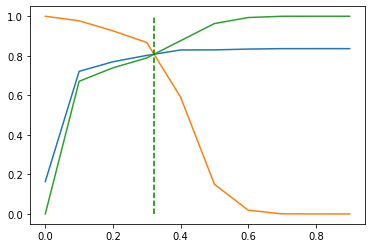

In [30]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_smote_40 = calculate_labels_at_diff_thresholds(train_pred_df_smote_40)
plt.plot(cutoff_df_smote_40['prob'], cutoff_df_smote_40['accuracy'])
plt.plot(cutoff_df_smote_40['prob'], cutoff_df_smote_40['sensi'])
plt.plot(cutoff_df_smote_40['prob'], cutoff_df_smote_40['speci'])
plt.vlines(x=.32, ymax=1, ymin=0, colors='g', linestyles='--')

In [31]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_smote_40['final_predicted'] = train_pred_df_smote_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_smote_40 else 0)
evaluate_model(train_pred_df_smote_40, pred='final_predicted')
train_pred_df_smote_40.head()

       thresholds       tpr       fpr      spec      diff
14143    0.336454  0.815153  0.186037  0.813963  0.001190
14144    0.336427  0.815181  0.186037  0.813963  0.001219
14145    0.336416  0.815181  0.186048  0.813952  0.001230
14146    0.336359  0.815238  0.186088  0.813912  0.001326
14147    0.336305  0.815238  0.186104  0.813896  0.001343
Accuracy: 0.816, Recall: 0.804, Precision: 0.464, F1-score: 0.589, AUC: 0.881, Specificity: 0.818, G-Mean: 0.811, Optimal Threshold: 0.34


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.476551,0,1,1,1,1,1,0,0,0,0,0,1
1,0,0.001166,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.000658,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.000076,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.001204,0,1,0,0,0,0,0,0,0,0,0,0


In [32]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model_smote_40, lr_X_val_40, train_cols_smote_40, lr_y_val_40, opt_threshold_smote_40)

Accuracy: 0.815, Recall: 0.789, Precision: 0.462, F1-score: 0.583, AUC: 0.878, Specificity: 0.82, G-Mean: 0.804


### 2.3 **ADASYN data**


In [33]:
# Automated feature selection

logreg_rfe_ada_40 = linear_model.LogisticRegression()
logreg_rfe_ada_40.fit(X_train_low_40_adasyn, y_train_low_40_adasyn)
col_ada_40 = rfe_feature_selection(logreg_rfe_ada_40, X_train_low_40_adasyn, y_train_low_40_adasyn, 15)

15


In [34]:
# Fit model with 15 cols

col_1_ada_40 = col_ada_40.copy()
mod_1_ada_40, lm_1_ada_40 = run_statsmodel(X_train_low_40_adasyn[col_1_ada_40], y_train_low_40_adasyn)
mod_1_ada_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               211558
Model:                            GLM   Df Residuals:                   211542
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -80979.
Date:                Thu, 18 Aug 2022   Deviance:                   1.6196e+05
Time:                        15:42:38   Pearson chi2:                 1.87e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1133
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4519      0.044    -55.996      0.000      -2.538      -2.366
Age                         -0.2417      0.010    -24.729      0.000      -0.261      -0.223
Previously_Insured          -4.6056      0.172    -26.701      0.000      -4.944      -4.268
Vehicle_Damage               1.3830      0.044     31.686      0.000       1.297       1.469
Less_than_1_year            -0.2024      0.028     -7.348      0.000      -0.256      -0.148
Region_Code_11               0.2936      0.046      6.315      0.000       0.202       0.385
Region_Code_14               0.2209      0.074      2.998      0.003       0.076       0.365
Region_Code_18               0.4618      0.059      7.837      0.000       0.346       0.577
Region_Code_3                0.2015      0.041      4.944      0.000       0.122       0.281
Region_Code_30               0.2093      0.049      4.296      0.000       0.114       0.305
Region_Code_35               0.2537      0.049      5.184      0.000       0.158       0.350
Region_Code_41               0.2040      0.030      6.715      0.000       0.144       0.264
Region_Code_48              -0.4938      0.077     -6.441      0.000      -0.644      -0.344
Region_Code_50              -0.3306      0.059     -5.633      0.000      -0.446      -0.216
Policy_Sales_Channel_152    -0.7313      0.032    -22.652      0.000      -0.795      -0.668
Policy_Sales_Channel_160    -1.3531      0.069    -19.735      0.000      -1.488      -1.219
============================================================================================
"""

In [35]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_ada_40, lr_cm_1_ada_40, lr_VIF_1_ada_40 = calculate_accuracy_vif(lm_1_ada_40, col_1_ada_40, X_train_low_40_adasyn, y_train_low_40_adasyn)
lr_VIF_1_ada_40

Accuracy of Model is 0.838
[[177296      0]
 [ 34262      0]]


,Features,VIF
3,Less_than_1_year,5.69
13,Policy_Sales_Channel_152,4.35
0,Age,2.14
1,Previously_Insured,2.04
2,Vehicle_Damage,1.71
14,Policy_Sales_Channel_160,1.49
10,Region_Code_41,1.06
8,Region_Code_30,1.05
4,Region_Code_11,1.03
7,Region_Code_3,1.03


In [36]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_ada_40.remove('Less_than_1_year')

col_2_ada_40 = col_1_ada_40.copy()
mod_2_ada_40, lm_2_ada_40 = run_statsmodel(X_train_low_40_adasyn[col_2_ada_40], y_train_low_40_adasyn)
mod_2_ada_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               211558
Model:                            GLM   Df Residuals:                   211543
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81007.
Date:                Thu, 18 Aug 2022   Deviance:                   1.6201e+05
Time:                        15:42:46   Pearson chi2:                 1.87e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1131
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4868      0.044    -57.112      0.000      -2.572      -2.402
Age                         -0.2100      0.009    -24.012      0.000      -0.227      -0.193
Previously_Insured          -4.6078      0.172    -26.714      0.000      -4.946      -4.270
Vehicle_Damage               1.3911      0.044     31.883      0.000       1.306       1.477
Region_Code_11               0.2959      0.046      6.367      0.000       0.205       0.387
Region_Code_14               0.2248      0.074      3.052      0.002       0.080       0.369
Region_Code_18               0.4648      0.059      7.891      0.000       0.349       0.580
Region_Code_3                0.2008      0.041      4.927      0.000       0.121       0.281
Region_Code_30               0.2095      0.049      4.297      0.000       0.114       0.305
Region_Code_35               0.2590      0.049      5.295      0.000       0.163       0.355
Region_Code_41               0.2047      0.030      6.738      0.000       0.145       0.264
Region_Code_48              -0.4941      0.077     -6.446      0.000      -0.644      -0.344
Region_Code_50              -0.3296      0.059     -5.617      0.000      -0.445      -0.215
Policy_Sales_Channel_152    -0.8655      0.027    -32.582      0.000      -0.918      -0.813
Policy_Sales_Channel_160    -1.4851      0.066    -22.453      0.000      -1.615      -1.355
============================================================================================
"""

In [37]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_ada_40, lr_cm_2_ada_40, lr_VIF_2_ada_40 = calculate_accuracy_vif(lm_2_ada_40, col_2_ada_40, X_train_low_40_adasyn, y_train_low_40_adasyn)
lr_VIF_2_ada_40

Accuracy of Model is 0.838
[[177296      0]
 [ 34262      0]]


,Features,VIF
12,Policy_Sales_Channel_152,2.47
1,Previously_Insured,1.91
0,Age,1.71
2,Vehicle_Damage,1.46
13,Policy_Sales_Channel_160,1.22
9,Region_Code_41,1.06
7,Region_Code_30,1.05
3,Region_Code_11,1.03
6,Region_Code_3,1.03
11,Region_Code_50,1.03


In [38]:
# Training predictions and Confusion matrix

train_pred_model_ada_40 = lm_2_ada_40
train_cols_ada_40 = col_2_ada_40
train_pred_df_ada_40 = lr_y_train_pred_final_2_ada_40
train_pred_cm_ada_40 = lr_cm_2_ada_40

In [39]:
# Evaluate model

_, _, _, opt_threshold_ada_40 = evaluate_model(train_pred_df_ada_40, pred='Predicted')

       thresholds       tpr       fpr      spec      diff
15918    0.226889  0.642169  0.354870  0.645130  0.002961
15917    0.226894  0.642169  0.354847  0.645153  0.002984
15916    0.226894  0.642111  0.354847  0.645153  0.003042
15915    0.226901  0.642111  0.354819  0.645181  0.003070
15914    0.226902  0.642082  0.354819  0.645181  0.003099
Accuracy: 0.838, Recall: 0.0, Precision: 0.0, F1-score: 0.0, AUC: 0.714, Specificity: 1.0, G-Mean: 0.0, Optimal Threshold: 0.23


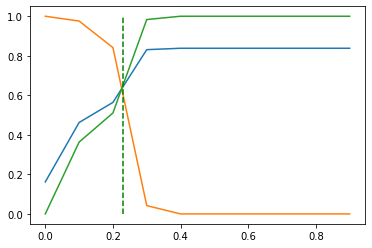

In [40]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_ada_40 = calculate_labels_at_diff_thresholds(train_pred_df_ada_40)
plt.plot(cutoff_df_ada_40['prob'], cutoff_df_ada_40['accuracy'])
plt.plot(cutoff_df_ada_40['prob'], cutoff_df_ada_40['sensi'])
plt.plot(cutoff_df_ada_40['prob'], cutoff_df_ada_40['speci'])
plt.vlines(x=.23, ymax=1, ymin=0, colors='g', linestyles='--')

In [41]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_ada_40['final_predicted'] = train_pred_df_ada_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_ada_40 else 0)
evaluate_model(train_pred_df_ada_40, pred='final_predicted')
train_pred_df_ada_40.head()

       thresholds       tpr       fpr      spec      diff
15918    0.226889  0.642169  0.354870  0.645130  0.002961
15917    0.226894  0.642169  0.354847  0.645153  0.002984
15916    0.226894  0.642111  0.354847  0.645153  0.003042
15915    0.226901  0.642111  0.354819  0.645181  0.003070
15914    0.226902  0.642082  0.354819  0.645181  0.003099
Accuracy: 0.656, Recall: 0.605, Precision: 0.259, F1-score: 0.363, AUC: 0.714, Specificity: 0.666, G-Mean: 0.635, Optimal Threshold: 0.23


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.236710,0,1,1,1,0,0,0,0,0,0,0,1
1,0,0.001027,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.001038,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.000372,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.001041,0,1,0,0,0,0,0,0,0,0,0,0


In [42]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model_ada_40, lr_X_val_40, train_cols_ada_40, lr_y_val_40, opt_threshold_ada_40)

Accuracy: 0.822, Recall: 0.615, Precision: 0.467, F1-score: 0.531, AUC: 0.876, Specificity: 0.862, G-Mean: 0.728


### 2.4 **GAN data**


In [43]:
# Automated feature selection

logreg_rfe_gan_40 = linear_model.LogisticRegression()
logreg_rfe_gan_40.fit(X_train_low_40_gan, y_train_low_40_gan)
col_gan_40 = rfe_feature_selection(logreg_rfe_gan_40, X_train_low_40_gan, y_train_low_40_gan, 15)

15


In [44]:
# Fit model with 15 cols

col_1_gan_40 = col_gan_40.copy()
mod_1_gan_40, lm_1_gan_40 = run_statsmodel(X_train_low_40_gan[col_1_gan_40], y_train_low_40_gan)
mod_1_gan_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               214004
Model:                            GLM   Df Residuals:                   213988
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63468.
Date:                Thu, 18 Aug 2022   Deviance:                   1.2694e+05
Time:                        15:44:03   Pearson chi2:                 2.35e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2328
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.7242      0.042    -64.741      0.000      -2.807      -2.642
Age                         -0.3160      0.010    -32.536      0.000      -0.335      -0.297
Previously_Insured          -2.4014      0.051    -47.051      0.000      -2.501      -2.301
Vehicle_Damage               2.2186      0.041     53.510      0.000       2.137       2.300
Less_than_1_year            -0.6451      0.028    -22.777      0.000      -0.701      -0.590
More_than_2_years            0.2764      0.024     11.292      0.000       0.228       0.324
Region_Code_10              -0.2296      0.111     -2.076      0.038      -0.446      -0.013
Region_Code_47              -0.3098      0.059     -5.223      0.000      -0.426      -0.194
Region_Code_48              -0.5376      0.068     -7.912      0.000      -0.671      -0.404
Region_Code_50              -0.4175      0.056     -7.516      0.000      -0.526      -0.309
Policy_Sales_Channel_152    -1.0157      0.032    -31.415      0.000      -1.079      -0.952
Policy_Sales_Channel_154     0.2437      0.040      6.085      0.000       0.165       0.322
Policy_Sales_Channel_156     0.2540      0.032      8.048      0.000       0.192       0.316
Policy_Sales_Channel_157     0.2791      0.040      6.938      0.000       0.200       0.358
Policy_Sales_Channel_160    -1.5810      0.070    -22.552      0.000      -1.718      -1.444
Policy_Sales_Channel_26      0.3306      0.015     21.351      0.000       0.300       0.361
============================================================================================
"""

In [45]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_gan_40, lr_cm_1_gan_40, lr_VIF_1_gan_40 = calculate_accuracy_vif(lm_1_gan_40, col_1_gan_40, X_train_low_40_gan, y_train_low_40_gan)
lr_VIF_1_gan_40

Accuracy of Model is 0.844
[[179839   1269]
 [ 32039    857]]


,Features,VIF
3,Less_than_1_year,5.81
9,Policy_Sales_Channel_152,4.56
1,Previously_Insured,2.64
0,Age,2.13
2,Vehicle_Damage,1.88
14,Policy_Sales_Channel_26,1.54
13,Policy_Sales_Channel_160,1.41
4,More_than_2_years,1.10
11,Policy_Sales_Channel_156,1.06
10,Policy_Sales_Channel_154,1.03


In [46]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_gan_40.remove('Less_than_1_year')

col_2_gan_40 = col_1_gan_40.copy()
mod_2_gan_40, lm_2_gan_40 = run_statsmodel(X_train_low_40_gan[col_2_gan_40], y_train_low_40_gan)
mod_2_gan_40

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               214004
Model:                            GLM   Df Residuals:                   213989
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63735.
Date:                Thu, 18 Aug 2022   Deviance:                   1.2747e+05
Time:                        15:44:12   Pearson chi2:                 2.42e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2309
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8436      0.042    -68.072      0.000      -2.925      -2.762
Age                         -0.2374      0.009    -26.369      0.000      -0.255      -0.220
Previously_Insured          -2.4248      0.051    -47.539      0.000      -2.525      -2.325
Vehicle_Damage               2.2527      0.041     54.386      0.000       2.171       2.334
More_than_2_years            0.2915      0.024     11.937      0.000       0.244       0.339
Region_Code_10              -0.2844      0.110     -2.578      0.010      -0.501      -0.068
Region_Code_47              -0.3296      0.059     -5.573      0.000      -0.446      -0.214
Region_Code_48              -0.5220      0.068     -7.696      0.000      -0.655      -0.389
Region_Code_50              -0.4196      0.055     -7.572      0.000      -0.528      -0.311
Policy_Sales_Channel_152    -1.4022      0.028    -50.507      0.000      -1.457      -1.348
Policy_Sales_Channel_154     0.2478      0.040      6.206      0.000       0.170       0.326
Policy_Sales_Channel_156     0.2524      0.031      8.016      0.000       0.191       0.314
Policy_Sales_Channel_157     0.3068      0.040      7.650      0.000       0.228       0.385
Policy_Sales_Channel_160    -1.9734      0.068    -29.001      0.000      -2.107      -1.840
Policy_Sales_Channel_26      0.3334      0.015     21.569      0.000       0.303       0.364
============================================================================================
"""

In [47]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_gan_40, lr_cm_2_gan_40, lr_VIF_2_gan_40 = calculate_accuracy_vif(lm_2_gan_40, col_2_gan_40, X_train_low_40_gan, y_train_low_40_gan)
lr_VIF_2_gan_40

Accuracy of Model is 0.845
[[180534    574]
 [ 32510    386]]


,Features,VIF
8,Policy_Sales_Channel_152,2.89
1,Previously_Insured,2.33
0,Age,1.79
2,Vehicle_Damage,1.77
13,Policy_Sales_Channel_26,1.53
12,Policy_Sales_Channel_160,1.22
3,More_than_2_years,1.10
10,Policy_Sales_Channel_156,1.06
9,Policy_Sales_Channel_154,1.03
11,Policy_Sales_Channel_157,1.03


In [48]:
# Training predictions and Confusion matrix

train_pred_model_gan_40 = lm_2_gan_40
train_cols_gan_40 = col_2_gan_40
train_pred_df_gan_40 = lr_y_train_pred_final_2_gan_40
train_pred_cm_gan_40 = lr_cm_2_gan_40

In [49]:
# Evaluate model

fpr_gan_40, tpr_gan_40, thresholds_gan_40, opt_threshold_gan_40 = evaluate_model(train_pred_df_gan_40, pred='Predicted')

      thresholds       tpr       fpr      spec      diff
1597    0.318503  0.783044  0.216120  0.783880  0.000837
1596    0.318576  0.782922  0.216120  0.783880  0.000958
1598    0.318276  0.784320  0.216733  0.783267  0.001053
1599    0.318215  0.784381  0.216749  0.783251  0.001130
1600    0.317936  0.784655  0.217158  0.782842  0.001812
Accuracy: 0.845, Recall: 0.012, Precision: 0.402, F1-score: 0.023, AUC: 0.857, Specificity: 0.997, G-Mean: 0.109, Optimal Threshold: 0.32


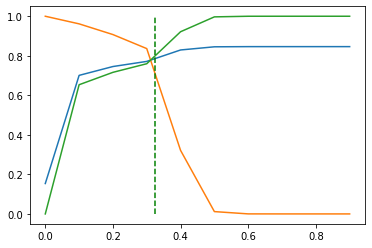

In [50]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_gan_40 = calculate_labels_at_diff_thresholds(train_pred_df_gan_40)
plt.plot(cutoff_df_gan_40['prob'], cutoff_df_gan_40['accuracy'])
plt.plot(cutoff_df_gan_40['prob'], cutoff_df_gan_40['sensi'])
plt.plot(cutoff_df_gan_40['prob'], cutoff_df_gan_40['speci'])
plt.vlines(x=.325, ymax=1, ymin=0, colors='g', linestyles='--')

In [51]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_gan_40['final_predicted'] = train_pred_df_gan_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_gan_40 else 0)
evaluate_model(train_pred_df_gan_40, pred='final_predicted')
train_pred_df_gan_40.head()

      thresholds       tpr       fpr      spec      diff
1597    0.318503  0.783044  0.216120  0.783880  0.000837
1596    0.318576  0.782922  0.216120  0.783880  0.000958
1598    0.318276  0.784320  0.216733  0.783267  0.001053
1599    0.318215  0.784381  0.216749  0.783251  0.001130
1600    0.317936  0.784655  0.217158  0.782842  0.001812
Accuracy: 0.785, Recall: 0.777, Precision: 0.398, F1-score: 0.526, AUC: 0.857, Specificity: 0.786, G-Mean: 0.781, Optimal Threshold: 0.32


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.415239,0,1,1,1,1,1,0,0,0,0,0,1
1,0,0.009081,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.004935,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.001359,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.009223,0,1,0,0,0,0,0,0,0,0,0,0


In [52]:
# Evaluate model on test data

evaluate_model_on_test_data(train_pred_model_gan_40, lr_X_val_40, train_cols_gan_40, lr_y_val_40, opt_threshold_gan_40)

Accuracy: 0.803, Recall: 0.83, Precision: 0.445, F1-score: 0.579, AUC: 0.874, Specificity: 0.797, G-Mean: 0.813


In [53]:
# Save models

joblib.dump(train_pred_model_40, 'lr_40_base.pkl')
joblib.dump(train_pred_model_smote_40, 'lr_40_smote.pkl')
joblib.dump(train_pred_model_ada_40, 'lr_40_adasyn.pkl')
joblib.dump(train_pred_model_gan_40, 'lr_40_gan.pkl')

['lr_40_gan.pkl']

## 3. Random Forest
### 3.1 Base Data

In [54]:
# Function for random forest model

def run_random_forest(df_X, df_y, params_grid, scoring):
    best_score_rf = []
    best_estimator_rf = []
    sk_rf = model_selection.StratifiedKFold(n_splits=5)
    for train_ind_base, test_ind_base in sk_rf.split(df_X, df_y):
        X_train_cv, X_test_cv = df_X[train_ind_base], df_X[test_ind_base] 
        y_train_cv, y_test_cv = np.array(df_y)[train_ind_base], np.array(df_y)[test_ind_base]
        print(X_train_cv.shape, y_train_cv.shape, X_test_cv.shape, y_test_cv.shape)
        rf_base = ensemble.RandomForestClassifier(n_jobs=-1, random_state=42)

        gs_rf = model_selection.GridSearchCV(rf_base,
                                             param_grid=params_grid, 
                                             scoring=scoring, 
                                             n_jobs=-1,
                                             verbose=1,
                                             cv=sk_rf, 
                                             return_train_score=True)
        gs_rf.fit(X_train_cv, y_train_cv)
        print(gs_rf.best_score_)
        print(gs_rf.best_estimator_)
        gs_rf_best = gs_rf.best_estimator_
        train_proba_vals = gs_rf_best.predict_proba(X_train_cv)[:,1]
        train_auc = metrics.roc_auc_score(y_train_cv, train_proba_vals)
        test_proba_vals = gs_rf_best.predict_proba(X_test_cv)[:,1]
        test_auc = metrics.roc_auc_score(y_test_cv, test_proba_vals)
        print(f"AUC score on train data is {train_auc}")
        print(f"AUC score on test data is {test_auc}")
        best_score_rf.append(test_auc)
        best_estimator_rf.append(gs_rf_best)
    rf_best = best_estimator_rf[best_score_rf.index(max(best_score_rf))]
    print(rf_best)
    return rf_best

def pca_train_test_data(train_data, test_data, percent_val, compnents_val):
    pca_base = PCA(random_state=42)
    pca_base.fit(train_data)
    var_cumu = np.cumsum(pca_base.explained_variance_ratio_)
    plt.figure(figsize=[12,8])
    plt.hlines(y=percent_val, xmax=40, xmin=0, colors='g', linestyles='--')
    plt.vlines(x=compnents_val, ymax=1, ymin=0, colors='g', linestyles='--')
    plt.plot(var_cumu)
    plt.ylabel('Cumulative Variance Explained')
    pca_final_base = PCA(n_components=compnents_val, random_state=42)
    train_scaled_X_pca_base = pca_final_base.fit_transform(train_data)
    test_scaled_X_pca_base = pca_final_base.transform(test_data)
    print(train_scaled_X_pca_base.shape, test_scaled_X_pca_base.shape)
    return train_scaled_X_pca_base, test_scaled_X_pca_base

(107002, 15) (45859, 15)


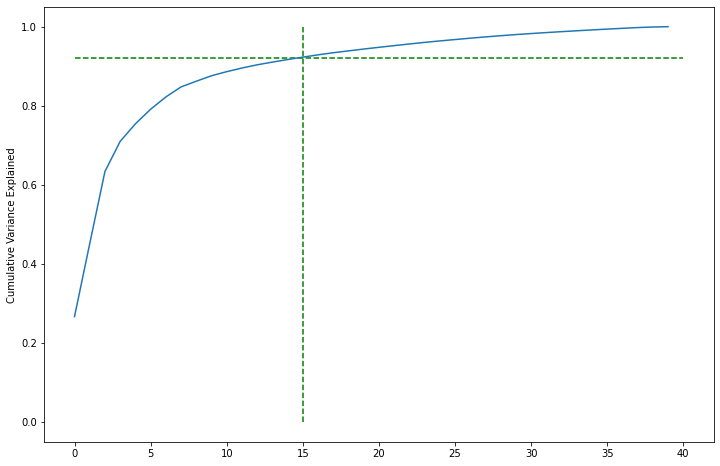

In [55]:
# Transform data

train_scaled_X_pca_base_40, test_scaled_X_pca_base_40 = pca_train_test_data(lr_X_train_40, lr_X_val_40, .92, 15)

In [56]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_base_40 = {    
    'max_depth' : [25],
    'max_leaf_nodes' : [60],
    'min_samples_leaf' : [20],
    'n_estimators' : [40],
}

# params_rf_base_40 = {
#     'n_estimators' : [17, 18, 19, 20],
#     'max_depth' : [12, 13, 14, 15, 16],
#     'min_samples_leaf' : [16, 17, 18, 19],
#     'max_leaf_nodes' : [35, 40, 45, 50]
# }

gs_rf_base_40 = run_random_forest(train_scaled_X_pca_base_40, lr_y_train_40, params_rf_base_40, 'roc_auc')

(85601, 15) (85601,) (21401, 15) (21401,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8892259953504658
RandomForestClassifier(max_depth=25, max_leaf_nodes=60, min_samples_leaf=20,
                       n_estimators=40, n_jobs=-1, random_state=42)
AUC score on train data is 0.8963548018194606
AUC score on test data is 0.8898747797851669
(85601, 15) (85601,) (21401, 15) (21401,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8901732471944734
RandomForestClassifier(max_depth=25, max_leaf_nodes=60, min_samples_leaf=20,
                       n_estimators=40, n_jobs=-1, random_state=42)
AUC score on train data is 0.8973329764150559
AUC score on test data is 0.8878954642398844
(85602, 15) (85602,) (21400, 15) (21400,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8888226815495918
RandomForestClassifier(max_depth=25, max_leaf_nodes=60, min_samples_leaf=20,
                       n_estimators=40, n_jobs=-1, random_state=42)
AUC score on train data

In [57]:
# Calculate labels using arbitrary threshold value

gs_rf_base_40.fit(train_scaled_X_pca_base_40, lr_y_train_40)
rf_train_pred_df_base_40,_,_ = calculate_accuracy(gs_rf_base_40, '', train_scaled_X_pca_base_40, lr_y_train_40, predict_proba=True)
rf_train_pred_df_base_40

,Converted,Conv_Prob,Predicted
0,1,0.511130,1
1,0,0.012461,0
2,0,0.011774,0
3,0,0.012872,0
4,0,0.014554,0
...,...,...,...
106997,0,0.021300,0
106998,0,0.007392,0
106999,0,0.459870,0
107000,0,0.523118,1


In [58]:
# find optimal threshold value

_, _, _, opt_threshold_rf_base_40 = evaluate_model(rf_train_pred_df_base_40, pred='Predicted')

       thresholds       tpr       fpr      spec      diff
13614    0.306031  0.822341  0.177728  0.822272  0.000069
13613    0.306036  0.822170  0.177716  0.822284  0.000113
13615    0.306009  0.822398  0.177728  0.822272  0.000126
13616    0.305959  0.822398  0.177750  0.822250  0.000148
13612    0.306038  0.822113  0.177716  0.822284  0.000170
Accuracy: 0.844, Recall: 0.203, Precision: 0.569, F1-score: 0.299, AUC: 0.895, Specificity: 0.97, G-Mean: 0.444, Optimal Threshold: 0.31


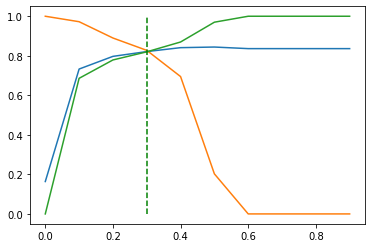

In [59]:
# Validate optimal threshold value

cutoff_df_rf_base_40 = calculate_labels_at_diff_thresholds(rf_train_pred_df_base_40)
plt.plot(cutoff_df_rf_base_40['prob'], cutoff_df_rf_base_40['accuracy'])
plt.plot(cutoff_df_rf_base_40['prob'], cutoff_df_rf_base_40['sensi'])
plt.plot(cutoff_df_rf_base_40['prob'], cutoff_df_rf_base_40['speci'])
plt.vlines(x=.3, ymax=1, ymin=0, colors='g', linestyles='--')

In [60]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_base_40['final_predicted'] = rf_train_pred_df_base_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_base_40 else 0)
evaluate_model(rf_train_pred_df_base_40, pred='final_predicted')
rf_train_pred_df_base_40.head()

       thresholds       tpr       fpr      spec      diff
13614    0.306031  0.822341  0.177728  0.822272  0.000069
13613    0.306036  0.822170  0.177716  0.822284  0.000113
13615    0.306009  0.822398  0.177728  0.822272  0.000126
13616    0.305959  0.822398  0.177750  0.822250  0.000148
13612    0.306038  0.822113  0.177716  0.822284  0.000170
Accuracy: 0.823, Recall: 0.818, Precision: 0.477, F1-score: 0.602, AUC: 0.895, Specificity: 0.824, G-Mean: 0.821, Optimal Threshold: 0.31


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.511130,1,1,1,1,1,1,1,0,0,0,0,1
1,0,0.012461,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.011774,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.012872,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.014554,0,1,0,0,0,0,0,0,0,0,0,0


In [61]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_base_40, test_scaled_X_pca_base_40, '', lr_y_val_40, opt_threshold_rf_base_40, predict_proba=True)

Accuracy: 0.818, Recall: 0.802, Precision: 0.468, F1-score: 0.591, AUC: 0.887, Specificity: 0.821, G-Mean: 0.811


In [62]:
# Save models

joblib.dump(gs_rf_base_40, 'rf_40_base.pkl')

['rf_40_base.pkl']

### 3.2 SMOTE Data

(214004, 15) (45859, 15)


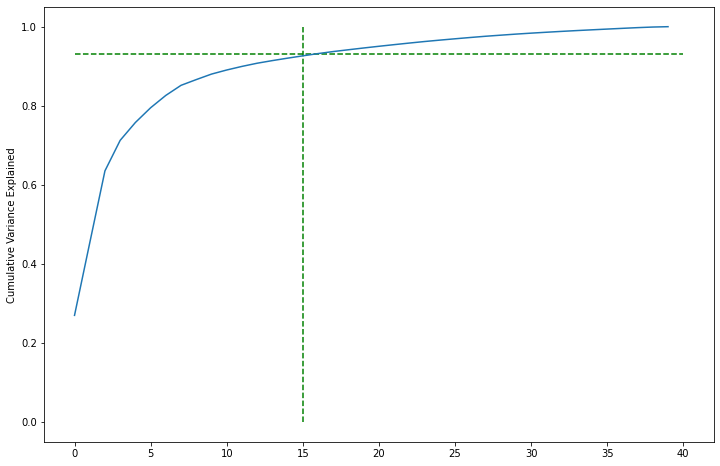

In [63]:
# Transform data

train_scaled_X_pca_smote_40, test_scaled_X_pca_smote_40 = pca_train_test_data(X_train_low_40_smote, lr_X_val_40, 0.93, 15)

In [64]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_smote_40 = {
    'n_estimators' : [25],
    'max_depth' : [15],
    'min_samples_leaf' : [20],
    'max_leaf_nodes' : [75]
}

gs_rf_smote_40 = run_random_forest(train_scaled_X_pca_smote_40, y_train_low_40_smote, params_rf_smote_40, 'roc_auc')

(171203, 15) (171203,) (42801, 15) (42801,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8952202772985093
RandomForestClassifier(max_depth=15, max_leaf_nodes=75, min_samples_leaf=20,
                       n_estimators=25, n_jobs=-1, random_state=42)
AUC score on train data is 0.8994261888465074
AUC score on test data is 0.891283992074547
(171203, 15) (171203,) (42801, 15) (42801,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8942229861285302
RandomForestClassifier(max_depth=15, max_leaf_nodes=75, min_samples_leaf=20,
                       n_estimators=25, n_jobs=-1, random_state=42)
AUC score on train data is 0.8992541319142522
AUC score on test data is 0.8949089302807558
(171203, 15) (171203,) (42801, 15) (42801,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.893662492888469
RandomForestClassifier(max_depth=15, max_leaf_nodes=75, min_samples_leaf=20,
                       n_estimators=25, n_jobs=-1, random_state=42)
AUC score on train 

In [65]:
# Calculate labels using arbitrary threshold value

gs_rf_smote_40.fit(train_scaled_X_pca_smote_40, y_train_low_40_smote)
rf_train_pred_df_smote_40, _, _ = calculate_accuracy(gs_rf_smote_40, '', train_scaled_X_pca_smote_40, y_train_low_40_smote, predict_proba=True)
rf_train_pred_df_smote_40

,Converted,Conv_Prob,Predicted
0,1,0.532573,1
1,0,0.007779,0
2,0,0.011782,0
3,0,0.009036,0
4,0,0.010806,0
...,...,...,...
213999,1,0.429691,0
214000,1,0.468367,0
214001,1,0.374592,0
214002,1,0.529792,1


In [66]:
# find optimal threshold value

_, _, _, opt_threshold_rf_smote_40 = evaluate_model(rf_train_pred_df_smote_40, pred='Predicted')

       thresholds       tpr       fpr      spec      diff
21882    0.307209  0.823796  0.176224  0.823776  0.000021
21881    0.307245  0.823768  0.176208  0.823792  0.000025
21883    0.307169  0.823796  0.176236  0.823764  0.000032
21880    0.307247  0.823739  0.176208  0.823792  0.000053
21884    0.307165  0.823825  0.176236  0.823764  0.000060
Accuracy: 0.848, Recall: 0.26, Precision: 0.578, F1-score: 0.358, AUC: 0.898, Specificity: 0.963, G-Mean: 0.5, Optimal Threshold: 0.31


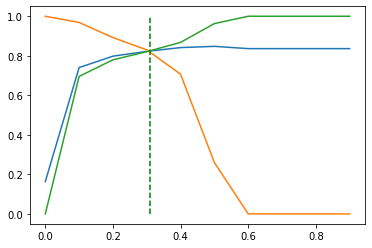

In [67]:
# Validate optimal threshold value

cutoff_df_rf_smote_40 = calculate_labels_at_diff_thresholds(rf_train_pred_df_smote_40)
plt.plot(cutoff_df_rf_smote_40['prob'], cutoff_df_rf_smote_40['accuracy'])
plt.plot(cutoff_df_rf_smote_40['prob'], cutoff_df_rf_smote_40['sensi'])
plt.plot(cutoff_df_rf_smote_40['prob'], cutoff_df_rf_smote_40['speci'])
plt.vlines(x=.31, ymax=1, ymin=0, colors='g', linestyles='--')

In [68]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_smote_40['final_predicted'] = rf_train_pred_df_smote_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_smote_40 else 0)
evaluate_model(rf_train_pred_df_smote_40, pred='final_predicted')
rf_train_pred_df_smote_40.head()

       thresholds       tpr       fpr      spec      diff
21882    0.307209  0.823796  0.176224  0.823776  0.000021
21881    0.307245  0.823768  0.176208  0.823792  0.000025
21883    0.307169  0.823796  0.176236  0.823764  0.000032
21880    0.307247  0.823739  0.176208  0.823792  0.000053
21884    0.307165  0.823825  0.176236  0.823764  0.000060
Accuracy: 0.825, Recall: 0.821, Precision: 0.479, F1-score: 0.605, AUC: 0.898, Specificity: 0.825, G-Mean: 0.823, Optimal Threshold: 0.31


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.532573,1,1,1,1,1,1,1,0,0,0,0,1
1,0,0.007779,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.011782,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.009036,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.010806,0,1,0,0,0,0,0,0,0,0,0,0


In [69]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_smote_40, test_scaled_X_pca_smote_40, '', lr_y_val_40, opt_threshold_rf_smote_40, predict_proba=True)

Accuracy: 0.82, Recall: 0.792, Precision: 0.471, F1-score: 0.59, AUC: 0.887, Specificity: 0.825, G-Mean: 0.808


In [70]:
# Save models

joblib.dump(gs_rf_smote_40, 'rf_40_smote.pkl')

['rf_40_smote.pkl']

## 3.3 ADASYN Data

(211558, 15) (45859, 15)


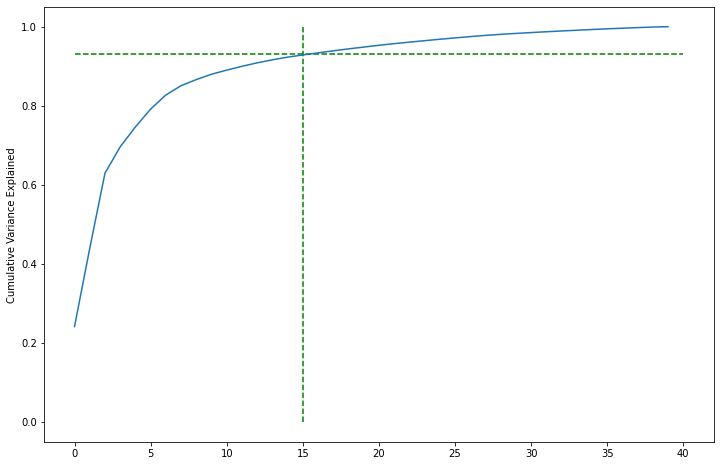

In [71]:
# Transform data

train_scaled_X_pca_ada_40, test_scaled_X_pca_ada_40 = pca_train_test_data(X_train_low_40_adasyn, lr_X_val_40, 0.93, 15)

In [72]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_ada_40 = {
    'n_estimators' : [55],
    'max_depth' : [20],
    'min_samples_leaf' : [8],
    'max_leaf_nodes' : [100]
}

gs_rf_ada_40 = run_random_forest(train_scaled_X_pca_ada_40, y_train_low_40_adasyn, params_rf_ada_40, 'roc_auc')

(169246, 15) (169246,) (42312, 15) (42312,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.6862664821727168
RandomForestClassifier(max_depth=20, max_leaf_nodes=100, min_samples_leaf=8,
                       n_estimators=55, n_jobs=-1, random_state=42)
AUC score on train data is 0.7293275568109773
AUC score on test data is 0.8930138307889349
(169246, 15) (169246,) (42312, 15) (42312,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.6851116877883147
RandomForestClassifier(max_depth=20, max_leaf_nodes=100, min_samples_leaf=8,
                       n_estimators=55, n_jobs=-1, random_state=42)
AUC score on train data is 0.7286397702863602
AUC score on test data is 0.8958005017001465
(169246, 15) (169246,) (42312, 15) (42312,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.7254480698642333
RandomForestClassifier(max_depth=20, max_leaf_nodes=100, min_samples_leaf=8,
                       n_estimators=55, n_jobs=-1, random_state=42)
AUC score on trai

In [73]:
# Calculate labels using arbitrary threshold value

gs_rf_ada_40.fit(train_scaled_X_pca_ada_40, y_train_low_40_adasyn)
rf_train_pred_df_ada_40, _, _ = calculate_accuracy(gs_rf_ada_40, '', train_scaled_X_pca_ada_40, y_train_low_40_adasyn, predict_proba=True)
rf_train_pred_df_ada_40

,Converted,Conv_Prob,Predicted
0,1,0.262355,0
1,0,0.032197,0
2,0,0.025227,0
3,0,0.016064,0
4,0,0.017889,0
...,...,...,...
211553,1,0.245035,0
211554,1,0.260504,0
211555,1,0.129379,0
211556,1,0.250397,0


In [74]:
# find optimal threshold value

_, _, _, opt_threshold_rf_ada_40 = evaluate_model(rf_train_pred_df_ada_40, pred='Predicted')

       thresholds       tpr       fpr      spec          diff
31570    0.231562  0.675588  0.324412  0.675588  3.973979e-07
31569    0.231566  0.675588  0.324395  0.675605  1.652346e-05
31568    0.231568  0.675559  0.324395  0.675605  4.571031e-05
31567    0.231569  0.675559  0.324390  0.675610  5.135060e-05
31571    0.231561  0.675646  0.324429  0.675571  7.569196e-05
Accuracy: 0.838, Recall: 0.001, Precision: 1.0, F1-score: 0.002, AUC: 0.758, Specificity: 1.0, G-Mean: 0.032, Optimal Threshold: 0.23


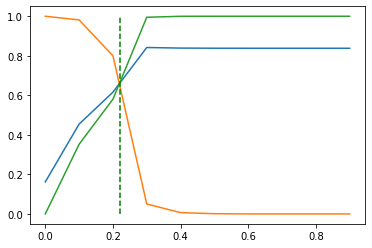

In [75]:
# Validate optimal threshold value

cutoff_df_rf_ada_40 = calculate_labels_at_diff_thresholds(rf_train_pred_df_ada_40)
plt.plot(cutoff_df_rf_ada_40['prob'], cutoff_df_rf_ada_40['accuracy'])
plt.plot(cutoff_df_rf_ada_40['prob'], cutoff_df_rf_ada_40['sensi'])
plt.plot(cutoff_df_rf_ada_40['prob'], cutoff_df_rf_ada_40['speci'])
plt.vlines(x=.22, ymax=1, ymin=0, colors='g', linestyles='--')

In [76]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_ada_40['final_predicted'] = rf_train_pred_df_ada_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_ada_40 else 0)
evaluate_model(rf_train_pred_df_ada_40, pred='final_predicted')
rf_train_pred_df_ada_40.head()

       thresholds       tpr       fpr      spec          diff
31570    0.231562  0.675588  0.324412  0.675588  3.973979e-07
31569    0.231566  0.675588  0.324395  0.675605  1.652346e-05
31568    0.231568  0.675559  0.324395  0.675605  4.571031e-05
31567    0.231569  0.675559  0.324390  0.675610  5.135060e-05
31571    0.231561  0.675646  0.324429  0.675571  7.569196e-05
Accuracy: 0.671, Recall: 0.686, Precision: 0.285, F1-score: 0.403, AUC: 0.758, Specificity: 0.668, G-Mean: 0.677, Optimal Threshold: 0.23


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.262355,0,1,1,1,0,0,0,0,0,0,0,1
1,0,0.032197,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.025227,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.016064,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.017889,0,1,0,0,0,0,0,0,0,0,0,0


In [77]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_ada_40, test_scaled_X_pca_ada_40, '', lr_y_val_40, opt_threshold_rf_ada_40, predict_proba=True)

Accuracy: 0.833, Recall: 0.678, Precision: 0.494, F1-score: 0.572, AUC: 0.887, Specificity: 0.864, G-Mean: 0.765


In [78]:
# Save models

joblib.dump(gs_rf_ada_40, 'rf_40_adasyn.pkl')

['rf_40_adasyn.pkl']

## 3.4 GAN Data

(214004, 17) (45859, 17)


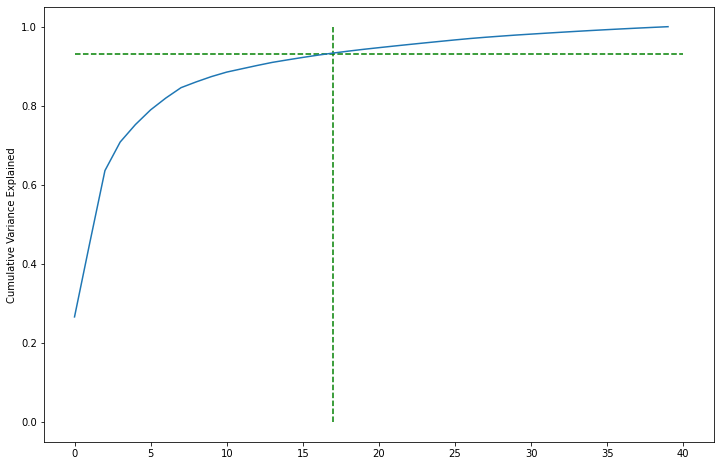

In [79]:
# Transform data

train_scaled_X_pca_gan_40, test_scaled_X_pca_gan_40 = pca_train_test_data(X_train_low_40_gan, lr_X_val_40, 0.93, 17)

In [80]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_gan_40 = {
    'n_estimators' : [45],
    'max_depth' : [20],
    'min_samples_leaf' : [10],
    'max_leaf_nodes' : [70]
}

gs_rf_gan_40 = run_random_forest(train_scaled_X_pca_gan_40, y_train_low_40_gan, params_rf_gan_40, 'roc_auc')

(171203, 17) (171203,) (42801, 17) (42801,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8572604195346807
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data is 0.866430221021876
AUC score on test data is 0.8866755871944175
(171203, 17) (171203,) (42801, 17) (42801,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8564734891337273
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train data is 0.8656418232159413
AUC score on test data is 0.8890034691659963
(171203, 17) (171203,) (42801, 17) (42801,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8626167777251037
RandomForestClassifier(max_depth=20, max_leaf_nodes=70, min_samples_leaf=10,
                       n_estimators=45, n_jobs=-1, random_state=42)
AUC score on train

In [81]:
# Calculate labels using arbitrary threshold value

gs_rf_gan_40.fit(train_scaled_X_pca_gan_40, y_train_low_40_gan)
rf_train_pred_df_gan_40, _, _ = calculate_accuracy(gs_rf_gan_40, '', train_scaled_X_pca_gan_40, y_train_low_40_gan, predict_proba=True)
rf_train_pred_df_gan_40

,Converted,Conv_Prob,Predicted
0,1,0.453908,0
1,0,0.009954,0
2,0,0.009148,0
3,0,0.006626,0
4,0,0.010939,0
...,...,...,...
213999,0,0.040129,0
214000,0,0.411022,0
214001,0,0.022572,0
214002,0,0.093091,0


In [82]:
# find optimal threshold value

_, _, _, opt_threshold_rf_gan_40 = evaluate_model(rf_train_pred_df_gan_40, pred='Predicted')

       thresholds       tpr       fpr      spec      diff
27810    0.277493  0.791221  0.208770  0.791230  0.000009
27809    0.277509  0.791221  0.208759  0.791241  0.000020
27811    0.277493  0.791251  0.208782  0.791218  0.000033
27808    0.277510  0.791160  0.208759  0.791241  0.000081
27807    0.277523  0.791160  0.208748  0.791252  0.000092
Accuracy: 0.847, Recall: 0.02, Precision: 0.589, F1-score: 0.038, AUC: 0.871, Specificity: 0.997, G-Mean: 0.141, Optimal Threshold: 0.28


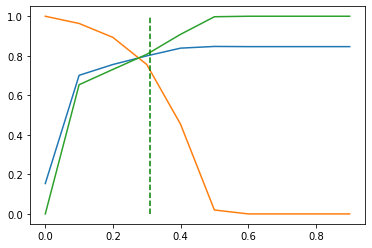

In [83]:
# Validate optimal threshold value

cutoff_df_rf_gan_40 = calculate_labels_at_diff_thresholds(rf_train_pred_df_gan_40)
plt.plot(cutoff_df_rf_gan_40['prob'], cutoff_df_rf_gan_40['accuracy'])
plt.plot(cutoff_df_rf_gan_40['prob'], cutoff_df_rf_gan_40['sensi'])
plt.plot(cutoff_df_rf_gan_40['prob'], cutoff_df_rf_gan_40['speci'])
plt.vlines(x=.31, ymax=1, ymin=0, colors='g', linestyles='--')

In [84]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_gan_40['final_predicted'] = rf_train_pred_df_gan_40.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_gan_40 else 0)
evaluate_model(rf_train_pred_df_gan_40, pred='final_predicted')
rf_train_pred_df_gan_40.head()

       thresholds       tpr       fpr      spec      diff
27810    0.277493  0.791221  0.208770  0.791230  0.000009
27809    0.277509  0.791221  0.208759  0.791241  0.000020
27811    0.277493  0.791251  0.208782  0.791218  0.000033
27808    0.277510  0.791160  0.208759  0.791241  0.000081
27807    0.277523  0.791160  0.208748  0.791252  0.000092
Accuracy: 0.792, Recall: 0.787, Precision: 0.409, F1-score: 0.538, AUC: 0.871, Specificity: 0.793, G-Mean: 0.79, Optimal Threshold: 0.28


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.453908,0,1,1,1,1,1,0,0,0,0,0,1
1,0,0.009954,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.009148,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.006626,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.010939,0,1,0,0,0,0,0,0,0,0,0,0


In [85]:
# validate model on unseen data

evaluate_model_on_test_data(gs_rf_gan_40, test_scaled_X_pca_gan_40, '', lr_y_val_40, opt_threshold_rf_gan_40, predict_proba=True)

Accuracy: 0.808, Recall: 0.84, Precision: 0.453, F1-score: 0.589, AUC: 0.885, Specificity: 0.801, G-Mean: 0.82


In [86]:
# Save models

joblib.dump(gs_rf_gan_40, 'rf_40_gan.pkl')

['rf_40_gan.pkl']